In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install git+https://github.com/IDEA-Research/GroundingDINO.git
!pip install opencv-python matplotlib pillow requests
!pip install groundingdino-py

# Weights folder
!mkdir -p /content/weights

# Download SAM checkpoint (ViT-Base)
!wget -O /content/weights/sam_vit_b_01ec64.pth \
  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

# Clone Grounded SAM 2 and download checkpoints
!git clone https://github.com/IDEA-Research/Grounded-SAM-2.git grounded_sam2
!cd grounded_sam2/checkpoints && bash download_ckpts.sh
!cd grounded_sam2/gdino_checkpoints && bash download_ckpts.sh

Looking in indexes: https://download.pytorch.org/whl/cu121
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-vgbeszgc
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-vgbeszgc
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=2e09e9c8f52223c1ad4c3b6c7620d5630675b9da7959c9593a3b28d115aae159
  Stored in directory: /tmp/pip-ephem-wheel-cache-ci1n77qx/wheels/29/82/ff/04e2be9805a1cb48bec0b85b5a6da6b63f647645750a0e42d4
Successfully built segment_anything
  Cloning https://github.com/IDEA-Research/GroundingDINO.git to /tmp/pip-req-build-qi9i5oxy
  Running command git clone --filter=blob:none --quiet https://github.com/IDEA-Research/GroundingDINO.git /tmp/pip-req-bu

final text_encoder_type: bert-base-uncased


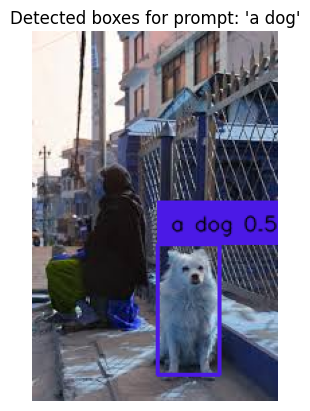

Mask 0: unique=[False  True], mean=0.0662


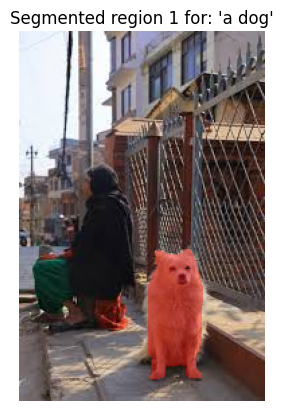

In [ ]:
import torch
import matplotlib.pyplot as plt
import cv2
import numpy as np
from segment_anything import sam_model_registry, SamPredictor
from groundingdino.util.inference import load_model, predict, annotate
import torchvision.transforms as transforms

# Checkpoint paths
SAM_WEIGHTS = '/content/weights/sam_vit_b_01ec64.pth'
GROUNDINGDINO_WEIGHTS = '/content/grounded_sam2/gdino_checkpoints/groundingdino_swint_ogc.pth'

# Load SAM model
sam = sam_model_registry["vit_b"](checkpoint=SAM_WEIGHTS)
sam.to(device='cuda' if torch.cuda.is_available() else 'cpu')
predictor = SamPredictor(sam)

# Load a sample image eg. A street scene with a person next to a dog
image_path = '/content/sample3.jpeg'
image = cv2.imread(image_path)

if image is None:
    print(f"Error: Could not load image from {image_path}")
else:
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Transformation to PyTorch Tensor (HWC to CHW, values [0, 1])
    transform = transforms.ToTensor()
    torch_tensor = transform(image)

    # SAM uses the raw NumPy image for its internal preprocessing
    predictor.set_image(image)

    # Give a text prompt
    text_prompt = "a dog"

    # Load pretrained Grounding DINO model
    gdino_model = load_model("/content/grounded_sam2/grounding_dino/groundingdino/config/GroundingDINO_SwinT_OGC.py", GROUNDINGDINO_WEIGHTS)

    # Get boxes from GroundingDINO for text prompt
    boxes_tensor, logits, phrases = predict(gdino_model, torch_tensor, text_prompt, 0.35, 0.25)

    annotated = annotate(image_source=image, boxes=boxes_tensor, logits=logits, phrases=phrases)
    plt.imshow(annotated)
    plt.title(f"Detected boxes for prompt: '{text_prompt}'")
    plt.axis("off")
    plt.show()

    # Check if any boxes were found before proceeding
    if boxes_tensor.shape[0] == 0:
        print(f"No objects found by Grounding DINO for the prompt: '{text_prompt}'")
    else:
        # Convert boxes from cx,cy,w,h → x_min,y_min,x_max,y_max
        boxes_np = boxes_tensor.cpu().numpy()
        if np.max(boxes_np) <= 1.1:
            h, w = image.shape[:2]
            boxes_np[:, [0, 2]] *= w
            boxes_np[:, [1, 3]] *= h

        # If Grounding DINO outputs cx,cy,w,h, convert to corners and check if values look like centers: cx < w, cy < h)
        if np.mean(boxes_np[:, 2]) < w / 2:
            cx, cy, bw, bh = boxes_np[:, 0], boxes_np[:, 1], boxes_np[:, 2], boxes_np[:, 3]
            x1 = cx - bw / 2
            y1 = cy - bh / 2
            x2 = cx + bw / 2
            y2 = cy + bh / 2
            boxes_np = np.stack([x1, y1, x2, y2], axis=1)

        boxes_tensor = torch.as_tensor(boxes_np, dtype=torch.float, device=predictor.device)
        transformed_boxes = predictor.transform.apply_boxes_torch(boxes_tensor, image.shape[:2])

        # Predict mask
        masks, scores, logits = predictor.predict_torch(
            point_coords=None,
            point_labels=None,
            boxes=transformed_boxes,
            multimask_output=False
        )

        # Visualize masks
        for i in range(masks.shape[0]):
            mask = masks[i].detach().cpu().numpy().squeeze()

            print(f"Mask {i}: unique={np.unique(mask)}, mean={mask.mean():.4f}")

            overlay = image.copy()
            overlay[mask > 0] = (255, 0, 0)  # red overlay
            blended = cv2.addWeighted(image, 0.6, overlay, 0.4, 0)

            plt.imshow(blended)
            plt.title(f"Segmented region {i+1} for: '{phrases[i]}'")
            plt.axis("off")
            plt.show()

